# LSTM Model dla prognozowania cen akcji

Ten notebook zawiera implementację modelu LSTM (Long Short-Term Memory) do prognozowania cen akcji.

## 1. Import bibliotek

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from typing import Dict, List, Tuple, Optional, Union, Any

# Dodanie katalogu głównego do ścieżki, aby móc importować moduły
sys.path.append('..')

from src.lstm_model import LSTMModel, LSTMTrainer, prepare_data_for_lstm
from src.utils import (
    create_directories, 
    plot_training_history, 
    plot_predictions, 
    evaluate_model, 
    print_metrics,
    save_model
)

# Ustawienie stylu dla wykresów
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style('whitegrid')
sns.set_context('talk')

# Sprawdzenie dostępności CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Używane urządzenie: {device}")

# Tworzenie potrzebnych katalogów
create_directories()

Używane urządzenie: cuda
Struktura katalogów utworzona pomyślnie.


## 2. Wczytanie danych

In [2]:
# Wczytanie przetworzonych danych
data_path = "../data/processed/cleaned_data.csv"

# Jeśli dane nie istnieją, uruchom preprocessing
if not os.path.exists(data_path):
    from src.data_preprocessing import preprocess
    df = preprocess()
else:
    df = pd.read_csv(data_path)
    df['Date'] = pd.to_datetime(df['Date'])

# Wyświetlenie pierwszych kilku wierszy
print(f"Liczba wierszy w danych: {len(df)}")
df.head()

Liczba wierszy w danych: 250


,Date,Close/Last,Volume,Open,High,Low
0,2024-05-08,174.72,79969490,171.590,176.0600,170.15
1,2024-05-09,171.97,65950290,175.010,175.6200,171.37
2,2024-05-10,168.47,72627180,173.050,173.0599,167.75
3,2024-05-13,171.89,67018900,170.000,175.4000,169.00
4,2024-05-14,177.55,86407420,174.496,179.4900,174.07


## 3. Przygotowanie danych dla modelu LSTM

In [3]:
# Wybór cech i celu
feature_cols = ['Open', 'High', 'Low', 'Volume']
target_col = 'Close/Last'

# Parametry sekwencji
seq_length = 20  # Liczba dni historycznych do przewidywania

# Przygotowanie danych
data = prepare_data_for_lstm(
    df=df,
    feature_cols=feature_cols,
    target_col=target_col,
    seq_length=seq_length,
    test_size=0.2,
    val_size=0.1,
    batch_size=32,
    shuffle=True
)

print(f"Liczba próbek treningowych: {len(data['X_train'])}")
print(f"Liczba próbek walidacyjnych: {len(data['X_val'])}")
print(f"Liczba próbek testowych: {len(data['X_test'])}")
print(f"Rozmiar danych wejściowych: {data['X_train'].shape}")

Liczba próbek treningowych: 161
Liczba próbek walidacyjnych: 23
Liczba próbek testowych: 46
Rozmiar danych wejściowych: (161, 20, 4)


## 4. Definicja modelu LSTM

In [4]:
# Parametry modelu
input_size = data['input_size']  # Liczba cech
hidden_size = 64  # Rozmiar warstwy ukrytej
num_layers = 2  # Liczba warstw LSTM
output_size = 1  # Predykcja jednej wartości (ceny zamknięcia)
dropout = 0.2  # Współczynnik dropout

# Inicjalizacja modelu
lstm_model = LSTMModel(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size,
    dropout=dropout
)

# Przeniesienie modelu na odpowiednie urządzenie (CPU/GPU)
lstm_model = lstm_model.to(device)

# Wyświetlenie struktury modelu
print(lstm_model)

LSTMModel(
  (lstm): LSTM(4, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


## 5. Trenowanie modelu LSTM

In [5]:
# Inicjalizacja trenera
trainer = LSTMTrainer(
    model=lstm_model,
    learning_rate=0.001,
    weight_decay=1e-5,
    device=device
)

# Parametry trenowania
epochs = 100
early_stopping_patience = 15

# Trenowanie modelu
history = trainer.fit(
    train_loader=data['train_loader'],
    val_loader=data['val_loader'],
    epochs=epochs,
    early_stopping_patience=early_stopping_patience,
    verbose=True
)

Epoka 1/100, Strata treningowa: 0.169805, Strata walidacyjna: 0.181502
Epoka 2/100, Strata treningowa: 0.080285, Strata walidacyjna: 0.025580
Epoka 3/100, Strata treningowa: 0.042383, Strata walidacyjna: 0.008635
Epoka 4/100, Strata treningowa: 0.037413, Strata walidacyjna: 0.007128
Epoka 5/100, Strata treningowa: 0.019890, Strata walidacyjna: 0.006252
Epoka 6/100, Strata treningowa: 0.010759, Strata walidacyjna: 0.067394
Epoka 7/100, Strata treningowa: 0.011286, Strata walidacyjna: 0.003405
Epoka 8/100, Strata treningowa: 0.010630, Strata walidacyjna: 0.033126
Epoka 9/100, Strata treningowa: 0.009009, Strata walidacyjna: 0.021708
Epoka 10/100, Strata treningowa: 0.008276, Strata walidacyjna: 0.008942
Epoka 11/100, Strata treningowa: 0.006843, Strata walidacyjna: 0.036459
Epoka 12/100, Strata treningowa: 0.009600, Strata walidacyjna: 0.013623
Epoka 13/100, Strata treningowa: 0.005469, Strata walidacyjna: 0.016328
Epoka 14/100, Strata treningowa: 0.005589, Strata walidacyjna: 0.014013
E

..\src\lstm_model.py:220: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load('models/lstm/best_model.pth'))


## 6. Analiza wyników treningu

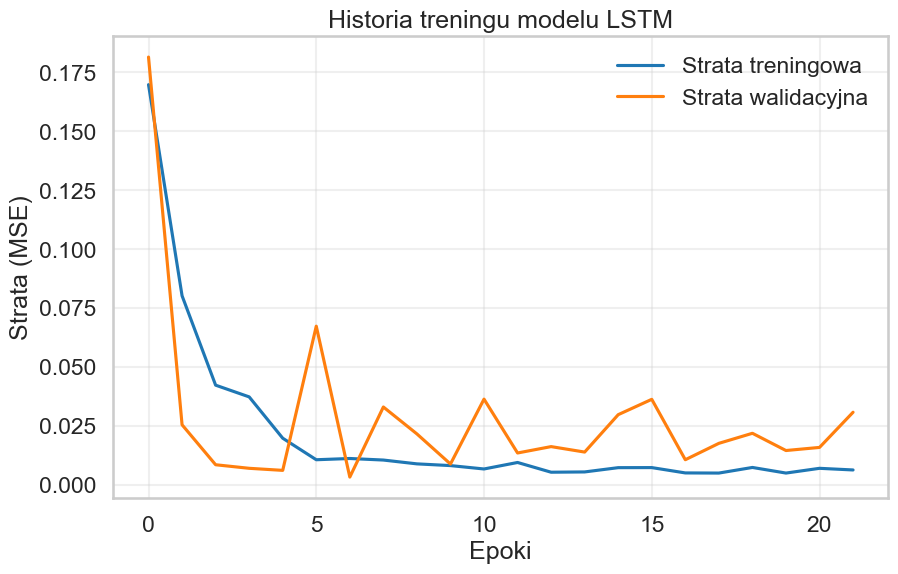

In [6]:
# Wykres historii treningu
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Strata treningowa')
plt.plot(history['val_loss'], label='Strata walidacyjna')
plt.title('Historia treningu modelu LSTM')
plt.xlabel('Epoki')
plt.ylabel('Strata (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 7. Ewaluacja modelu na zbiorze testowym

In [7]:
# Predykcja na zbiorze testowym
y_pred = trainer.predict(data['X_test'])

# Obliczenie metryk
metrics = evaluate_model(data['y_test'], y_pred, scaler=data['target_scaler'])
print_metrics(metrics)


=== Metryki wydajności modelu ===
MSE: 698.330805
RMSE: 26.425949
MAE: 21.729090
R²: -0.732997


## 8. Wizualizacja predykcji

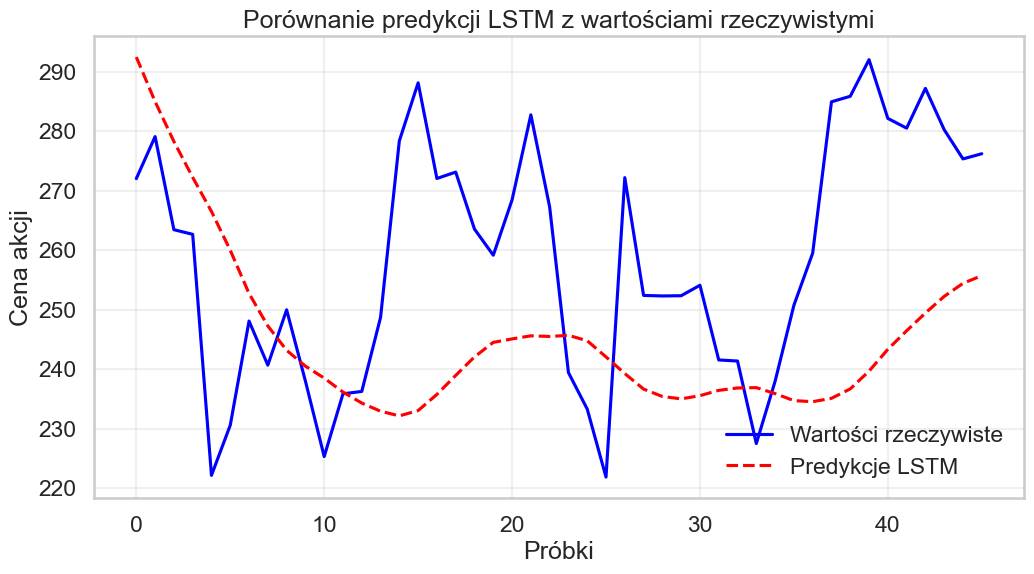

In [8]:
# Denormalizacja danych
y_test_denorm = data['target_scaler'].inverse_transform(data['y_test'])
y_pred_denorm = data['target_scaler'].inverse_transform(y_pred)

# Wizualizacja predykcji
plt.figure(figsize=(12, 6))
plt.plot(y_test_denorm, label='Wartości rzeczywiste', color='blue')
plt.plot(y_pred_denorm, label='Predykcje LSTM', color='red', linestyle='--')
plt.title('Porównanie predykcji LSTM z wartościami rzeczywistymi')
plt.xlabel('Próbki')
plt.ylabel('Cena akcji')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 9. Zapisanie modelu

In [9]:
# Przygotowanie metadanych
metadata = {
    'input_size': input_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'output_size': output_size,
    'dropout': dropout,
    'feature_cols': feature_cols,
    'target_col': target_col,
    'seq_length': seq_length,
    'metrics': metrics,
    'training_history': {
        'train_loss': [float(loss) for loss in history['train_loss']],
        'val_loss': [float(loss) for loss in history['val_loss']]
    }
}

# Zapisanie modelu
save_model(
    model=lstm_model,
    path='../models/lstm/lstm_model_complete.pth',
    metadata=metadata
)

Model zapisany w ../models/lstm/lstm_model_complete.pth


## 10. Badanie wpływu parametrów

In [10]:
# Ta sekcja jest opcjonalna - można użyć jej do eksperymentowania z różnymi parametrami modelu

def train_lstm_with_params(hidden_size, num_layers, learning_rate, epochs=50):
    """Trenowanie modelu LSTM z określonymi parametrami"""
    # Inicjalizacja modelu
    model = LSTMModel(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        output_size=output_size,
        dropout=0.2
    ).to(device)
    
    # Inicjalizacja trenera
    trainer = LSTMTrainer(
        model=model,
        learning_rate=learning_rate,
        weight_decay=1e-5,
        device=device
    )
    
    # Trenowanie
    history = trainer.fit(
        train_loader=data['train_loader'],
        val_loader=data['val_loader'],
        epochs=epochs,
        early_stopping_patience=10,
        verbose=False
    )
    
    # Ewaluacja
    y_pred = trainer.predict(data['X_test'])
    metrics = evaluate_model(data['y_test'], y_pred, scaler=data['target_scaler'])
    
    return {
        'model': model,
        'trainer': trainer,
        'history': history,
        'metrics': metrics,
        'params': {
            'hidden_size': hidden_size,
            'num_layers': num_layers,
            'learning_rate': learning_rate
        }
    }

# Definiowanie eksperymentów z różnymi parametrami
experiments = [
    {'hidden_size': 32, 'num_layers': 1, 'learning_rate': 0.001},
    {'hidden_size': 64, 'num_layers': 1, 'learning_rate': 0.001},
    {'hidden_size': 64, 'num_layers': 2, 'learning_rate': 0.001},
    {'hidden_size': 128, 'num_layers': 1, 'learning_rate': 0.001},
    {'hidden_size': 128, 'num_layers': 2, 'learning_rate': 0.001},
]

# Wykonanie eksperymentów
results = []

for i, exp in enumerate(experiments):
    print(f"Eksperyment {i+1}/{len(experiments)}: {exp}")
    result = train_lstm_with_params(**exp, epochs=50)
    results.append(result)
    print(f"RMSE: {result['metrics']['RMSE']:.6f}\n")

# Porównanie wyników
for i, result in enumerate(results):
    params = result['params']
    metrics = result['metrics']
    print(f"Model {i+1}: hidden_size={params['hidden_size']}, num_layers={params['num_layers']}, learning_rate={params['learning_rate']}")
    print(f"  RMSE: {metrics['RMSE']:.6f}, MAE: {metrics['MAE']:.6f}, R²: {metrics['R²']:.6f}")

Eksperyment 1/5: {'hidden_size': 32, 'num_layers': 1, 'learning_rate': 0.001}


..\src\lstm_model.py:220: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load('models/lstm/best_model.pth'))


RMSE: 25.884494

Eksperyment 2/5: {'hidden_size': 64, 'num_layers': 1, 'learning_rate': 0.001}


..\src\lstm_model.py:220: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load('models/lstm/best_model.pth'))


RMSE: 21.253741

Eksperyment 3/5: {'hidden_size': 64, 'num_layers': 2, 'learning_rate': 0.001}


..\src\lstm_model.py:220: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load('models/lstm/best_model.pth'))


RMSE: 27.258403

Eksperyment 4/5: {'hidden_size': 128, 'num_layers': 1, 'learning_rate': 0.001}


..\src\lstm_model.py:220: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load('models/lstm/best_model.pth'))


RMSE: 21.027960

Eksperyment 5/5: {'hidden_size': 128, 'num_layers': 2, 'learning_rate': 0.001}
RMSE: 22.357986

Model 1: hidden_size=32, num_layers=1, learning_rate=0.001
  RMSE: 25.884494, MAE: 21.043786, R²: -0.662708
Model 2: hidden_size=64, num_layers=1, learning_rate=0.001
  RMSE: 21.253741, MAE: 16.933540, R²: -0.121005
Model 3: hidden_size=64, num_layers=2, learning_rate=0.001
  RMSE: 27.258403, MAE: 22.648258, R²: -0.843900
Model 4: hidden_size=128, num_layers=1, learning_rate=0.001
  RMSE: 21.027960, MAE: 16.858818, R²: -0.097314
Model 5: hidden_size=128, num_layers=2, learning_rate=0.001
  RMSE: 22.357986, MAE: 18.088036, R²: -0.240515


..\src\lstm_model.py:220: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load('models/lstm/best_model.pth'))
